In [1]:
import pandas as pd
import numpy as np
import openmeteo_requests
import requests_cache
from retry_requests import retry

import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

In [14]:
cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=session)

# Berlin districts
locations = [
    (52.5200, 13.4050),   # Mitte
    (52.4986, 13.4031),   # Friedrichshain-Kreuzberg
    (52.5667, 13.4167),   # Pankow
    (52.4800, 13.4350),   # Neukölln
    (52.5070, 13.3300),   # Charlottenburg-Wilmersdorf
    (52.4660, 13.3777),   # Tempelhof-Schoneberg
    (52.4420, 13.5760),   # Treptow-Kopenick
    (52.5893, 13.3217),   # Reinickendorf
    (52.5202, 13.4996),   # Lichtenberg
    (52.5413, 13.5730),   # Marzahn-Hellersdorf
    (52.4308, 13.1926),   # Steglitz-Zehlendorf 
    (52.5351, 13.2002)    # Spandau
]

AQ_URL = "https://air-quality-api.open-meteo.com/v1/air-quality"
WX_URL = "https://archive-api.open-meteo.com/v1/archive"

aq_params = {
    "hourly": [
        "european_aqi", "european_aqi_pm2_5", "european_aqi_pm10",
        "pm10", "pm2_5", "carbon_monoxide", "carbon_dioxide",
        "nitrogen_dioxide", "sulphur_dioxide", "ozone",
        "european_aqi_nitrogen_dioxide", "european_aqi_ozone",
        "european_aqi_sulphur_dioxide"
    ],
    "start_date": "2023-01-01",
    "end_date": "2025-12-31",
    "timezone": "Europe/Berlin"
}

wx_params = {
    "hourly": [
        "temperature_2m","relative_humidity_2m","dewpoint_2m",
        "wind_speed_10m","wind_direction_10m","wind_gusts_10m",
        "precipitation","rain","snowfall",
        "surface_pressure","cloud_cover"
    ],
    "start_date": "2023-01-01",
    "end_date": "2025-12-31",
    "timezone": "Europe/Berlin"
}

dfs = []

for lat, lon in locations:
    p = aq_params.copy()
    p["latitude"] = lat
    p["longitude"] = lon
    aq = openmeteo.weather_api(AQ_URL, params=p)[0].Hourly()

    w = wx_params.copy()
    w["latitude"] = lat
    w["longitude"] = lon
    wx = openmeteo.weather_api(WX_URL, params=w)[0].Hourly()

    times = pd.date_range(
        start=pd.to_datetime(aq.Time(), unit="s", utc=True),
        end=pd.to_datetime(aq.TimeEnd(), unit="s", utc=True),
        freq=pd.Timedelta(seconds=aq.Interval()),
        inclusive="left"
    )

    df = pd.DataFrame({
        "date": times,
        "latitude": lat,
        "longitude": lon,
        "european_aqi": aq.Variables(0).ValuesAsNumpy(),
        "european_aqi_pm2_5": aq.Variables(1).ValuesAsNumpy(),
        "european_aqi_pm10": aq.Variables(2).ValuesAsNumpy(),
        "pm10": aq.Variables(3).ValuesAsNumpy(),
        "pm2_5": aq.Variables(4).ValuesAsNumpy(),
        "carbon_monoxide": aq.Variables(5).ValuesAsNumpy(),
        "carbon_dioxide": aq.Variables(6).ValuesAsNumpy(),
        "nitrogen_dioxide": aq.Variables(7).ValuesAsNumpy(),
        "sulphur_dioxide": aq.Variables(8).ValuesAsNumpy(),
        "ozone": aq.Variables(9).ValuesAsNumpy(),
        "temperature_2m": wx.Variables(0).ValuesAsNumpy(),
        "relative_humidity_2m": wx.Variables(1).ValuesAsNumpy(),
        "dewpoint_2m": wx.Variables(2).ValuesAsNumpy(),
        "wind_speed_10m": wx.Variables(3).ValuesAsNumpy(),
        "wind_direction_10m": wx.Variables(4).ValuesAsNumpy(),
        "wind_gusts_10m": wx.Variables(5).ValuesAsNumpy(),
        "precipitation": wx.Variables(6).ValuesAsNumpy(),
        "rain": wx.Variables(7).ValuesAsNumpy(),
        "snowfall": wx.Variables(8).ValuesAsNumpy(),
        "surface_pressure": wx.Variables(9).ValuesAsNumpy(),
        "cloud_cover": wx.Variables(10).ValuesAsNumpy()
    })

    dfs.append(df)

berlin = pd.concat(dfs, ignore_index=True)


In [15]:
bezirke = gpd.read_file("berliner-bezirke.geojson")

bezirke = bezirke.to_crs(epsg=4326)
print(bezirke.columns)


Index(['gml_id', 'spatial_name', 'spatial_alias', 'spatial_type', 'geometry'], dtype='object')


In [16]:
gdf = gpd.GeoDataFrame(
    berlin,
    geometry=gpd.points_from_xy(berlin.longitude, berlin.latitude),
    crs="EPSG:4326"
)

In [17]:
joined = gpd.sjoin(gdf, bezirke[['spatial_alias', 'geometry']], how="left", predicate="within")

berlin_with_boroughs = pd.DataFrame(joined.drop(columns=['geometry', 'index_right']))


In [18]:
berlin_with_boroughs.head()


,date,latitude,longitude,european_aqi,european_aqi_pm2_5,european_aqi_pm10,pm10,pm2_5,carbon_monoxide,carbon_dioxide,...,dewpoint_2m,wind_speed_10m,wind_direction_10m,wind_gusts_10m,precipitation,rain,snowfall,surface_pressure,cloud_cover,spatial_alias
0,2022-12-31 23:00:00+00:00,52.52,13.405,19.600000,9.441667,6.450000,12.5,9.800000,145.0,NaN,...,7.75,28.312117,228.608566,47.160000,0.0,0.0,0.0,1006.569153,100.0,Mitte
1,2023-01-01 00:00:00+00:00,52.52,13.405,20.000000,9.825000,6.695833,18.6,11.500000,148.0,NaN,...,7.20,30.532158,232.184204,49.680000,0.0,0.0,0.0,1006.381348,100.0,Mitte
2,2023-01-01 01:00:00+00:00,52.52,13.405,20.000000,10.391666,7.216667,23.4,16.700001,147.0,NaN,...,6.55,30.699368,230.710602,52.199997,0.0,0.0,0.0,1006.486938,100.0,Mitte
3,2023-01-01 02:00:00+00:00,52.52,13.405,21.199999,11.450001,7.979167,16.4,10.000000,140.0,NaN,...,6.00,31.259941,231.546265,52.199997,0.0,0.0,0.0,1006.886108,100.0,Mitte
4,2023-01-01 03:00:00+00:00,52.52,13.405,21.199999,11.991668,8.466666,17.1,10.800000,133.0,NaN,...,5.55,28.394392,230.659500,52.199997,0.0,0.0,0.0,1006.887695,100.0,Mitte


In [19]:
berlin_with_boroughs.shape

(315648, 25)

In [20]:
berlin_with_boroughs.spatial_alias.unique()

array(['Mitte', 'Friedrichshain-Kreuzberg', 'Pankow', 'Neukölln',
       'Charlottenburg-Wilmersdorf', 'Tempelhof-Schöneberg',
       'Treptow-Köpenick', 'Reinickendorf', 'Lichtenberg',
       'Marzahn-Hellersdorf', 'Steglitz-Zehlendorf', 'Spandau'],
      dtype=object)

In [21]:
berlin = berlin_with_boroughs

In [22]:
berlin.to_csv("berlin_air_quality_weather.csv", index=False)

In [23]:
berlin.columns

Index(['date', 'latitude', 'longitude', 'european_aqi', 'european_aqi_pm2_5',
       'european_aqi_pm10', 'pm10', 'pm2_5', 'carbon_monoxide',
       'carbon_dioxide', 'nitrogen_dioxide', 'sulphur_dioxide', 'ozone',
       'temperature_2m', 'relative_humidity_2m', 'dewpoint_2m',
       'wind_speed_10m', 'wind_direction_10m', 'wind_gusts_10m',
       'precipitation', 'rain', 'snowfall', 'surface_pressure', 'cloud_cover',
       'spatial_alias'],
      dtype='object')

In [24]:
berlin = berlin.dropna(subset=[
    "pm2_5",
    "pm10",
    "nitrogen_dioxide",
    "ozone",
    "sulphur_dioxide",
    "carbon_monoxide",
    "european_aqi",
    "temperature_2m",
    "relative_humidity_2m",
    "wind_speed_10m",
    "cloud_cover",
    "surface_pressure"
])

In [25]:
berlin.shape

(315648, 25)

In [26]:
berlin.dtypes

date                    datetime64[ns, UTC]
latitude                            float64
longitude                           float64
european_aqi                        float32
european_aqi_pm2_5                  float32
european_aqi_pm10                   float32
pm10                                float32
pm2_5                               float32
carbon_monoxide                     float32
carbon_dioxide                      float32
nitrogen_dioxide                    float32
sulphur_dioxide                     float32
ozone                               float32
temperature_2m                      float32
relative_humidity_2m                float32
dewpoint_2m                         float32
wind_speed_10m                      float32
wind_direction_10m                  float32
wind_gusts_10m                      float32
precipitation                       float32
rain                                float32
snowfall                            float32
surface_pressure                

In [27]:
berlin['spatial_alias'].nunique()

12

In [28]:
berlin['spatial_alias'].value_counts()

spatial_alias
Mitte                         26304
Friedrichshain-Kreuzberg      26304
Pankow                        26304
Neukölln                      26304
Charlottenburg-Wilmersdorf    26304
Tempelhof-Schöneberg          26304
Treptow-Köpenick              26304
Reinickendorf                 26304
Lichtenberg                   26304
Marzahn-Hellersdorf           26304
Steglitz-Zehlendorf           26304
Spandau                       26304
Name: count, dtype: int64

In [29]:
berlin.isna().sum()

date                         0
latitude                     0
longitude                    0
european_aqi                 0
european_aqi_pm2_5           0
european_aqi_pm10            0
pm10                         0
pm2_5                        0
carbon_monoxide              0
carbon_dioxide          191244
nitrogen_dioxide             0
sulphur_dioxide              0
ozone                        0
temperature_2m               0
relative_humidity_2m         0
dewpoint_2m                  0
wind_speed_10m               0
wind_direction_10m           0
wind_gusts_10m               0
precipitation                0
rain                         0
snowfall                     0
surface_pressure             0
cloud_cover                  0
spatial_alias                0
dtype: int64

In [30]:
berlin.duplicated().sum()

np.int64(0)

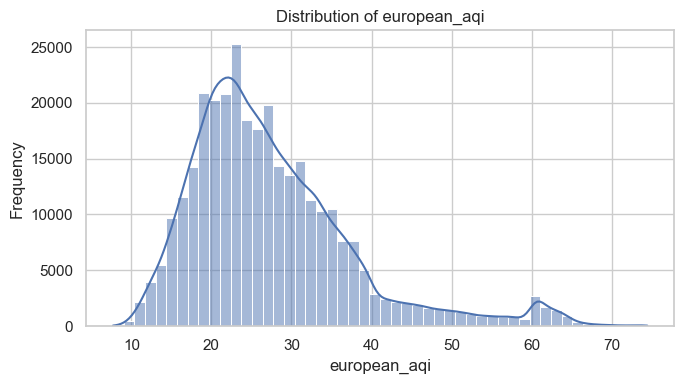

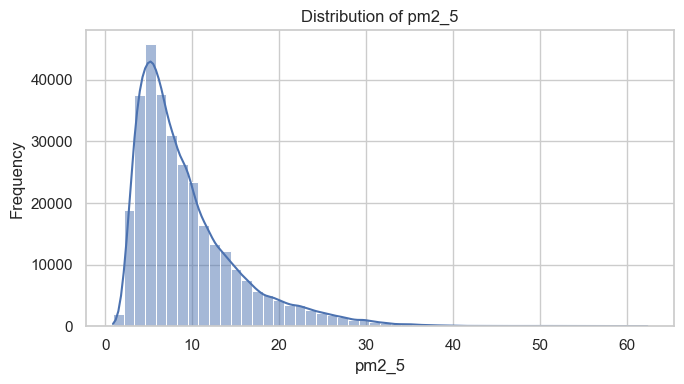

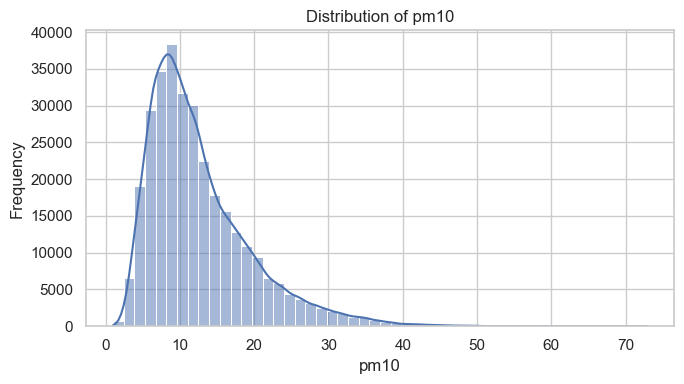

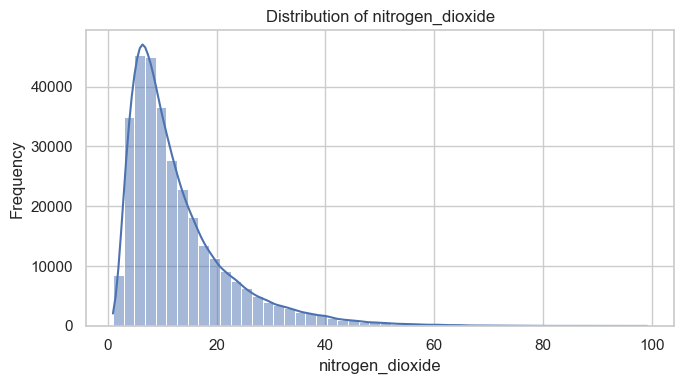

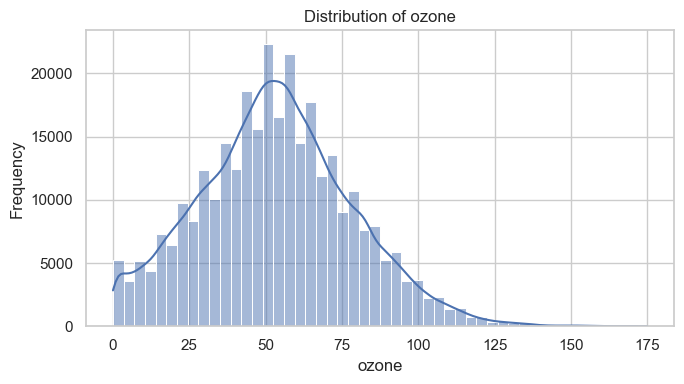

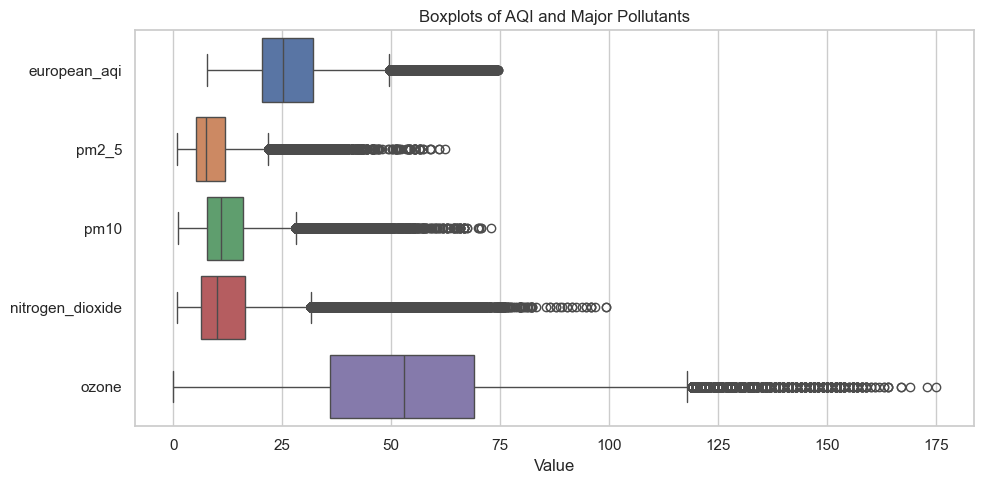

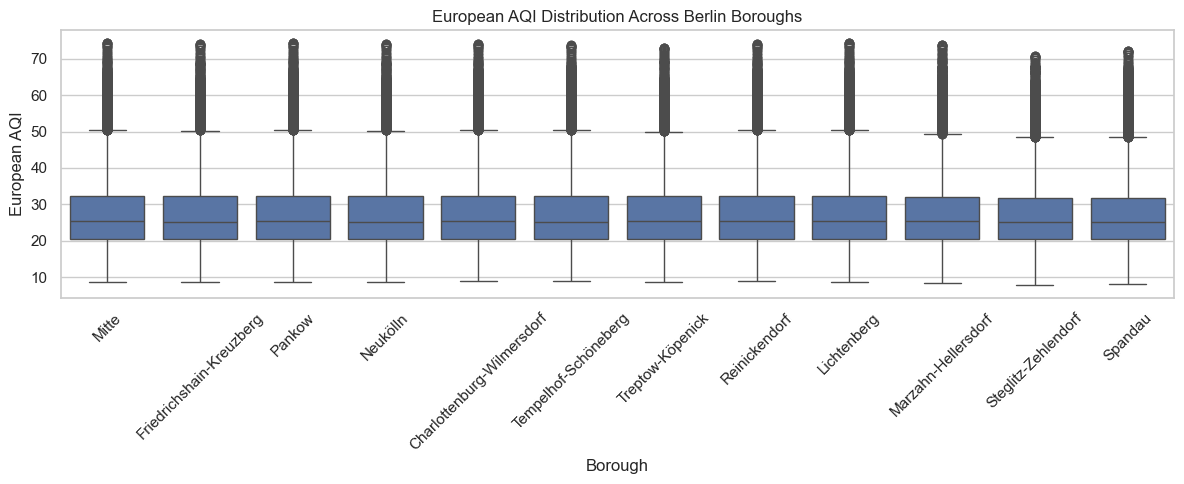

In [31]:
sns.set(style="whitegrid")

dist_vars = [
    "european_aqi",
    "pm2_5",
    "pm10",
    "nitrogen_dioxide",
    "ozone",
]

# ----------------------------------
# 1. Histogram + KDE for each variable
# ----------------------------------
for var in dist_vars:
    plt.figure(figsize=(7,4))
    sns.histplot(berlin[var], bins=50, kde=True)
    plt.title(f"Distribution of {var}")
    plt.xlabel(var)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# ----------------------------------
# 2. Boxplots (outlier detection)
# ----------------------------------
plt.figure(figsize=(10,5))
sns.boxplot(data=berlin[dist_vars], orient="h")
plt.title("Boxplots of AQI and Major Pollutants")
plt.xlabel("Value")
plt.tight_layout()
plt.show()

# ----------------------------------
# 3. Borough-wise AQI distribution (overview)
# ----------------------------------
plt.figure(figsize=(12,5))
sns.boxplot(
    data=berlin,
    x="spatial_alias",
    y="european_aqi"
)
plt.xticks(rotation=45)
plt.title("European AQI Distribution Across Berlin Boroughs")
plt.xlabel("Borough")
plt.ylabel("European AQI")
plt.tight_layout()
plt.show()


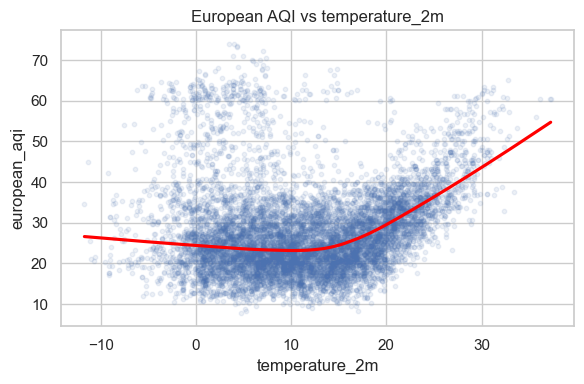

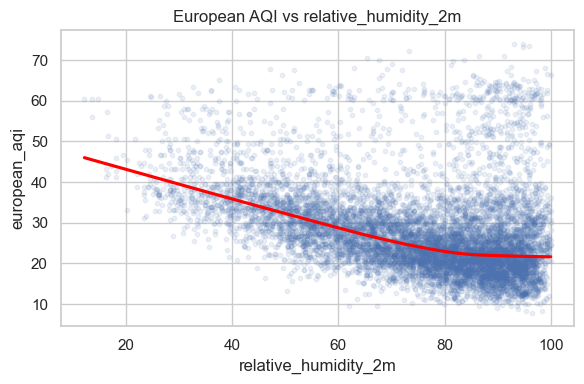

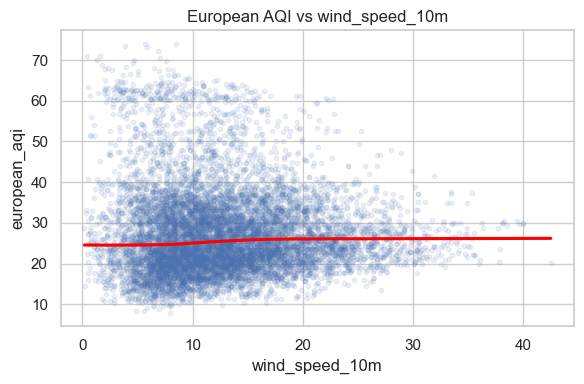

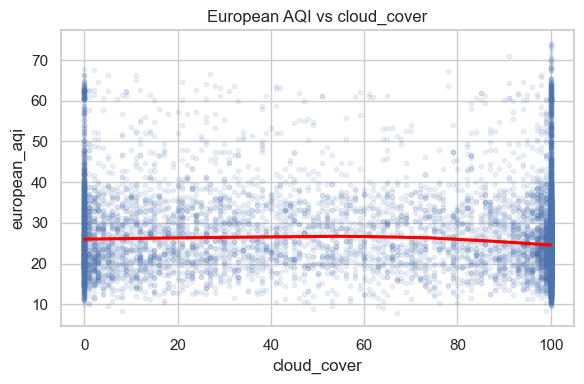

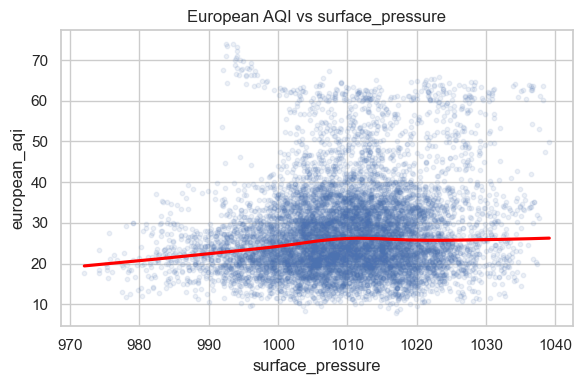

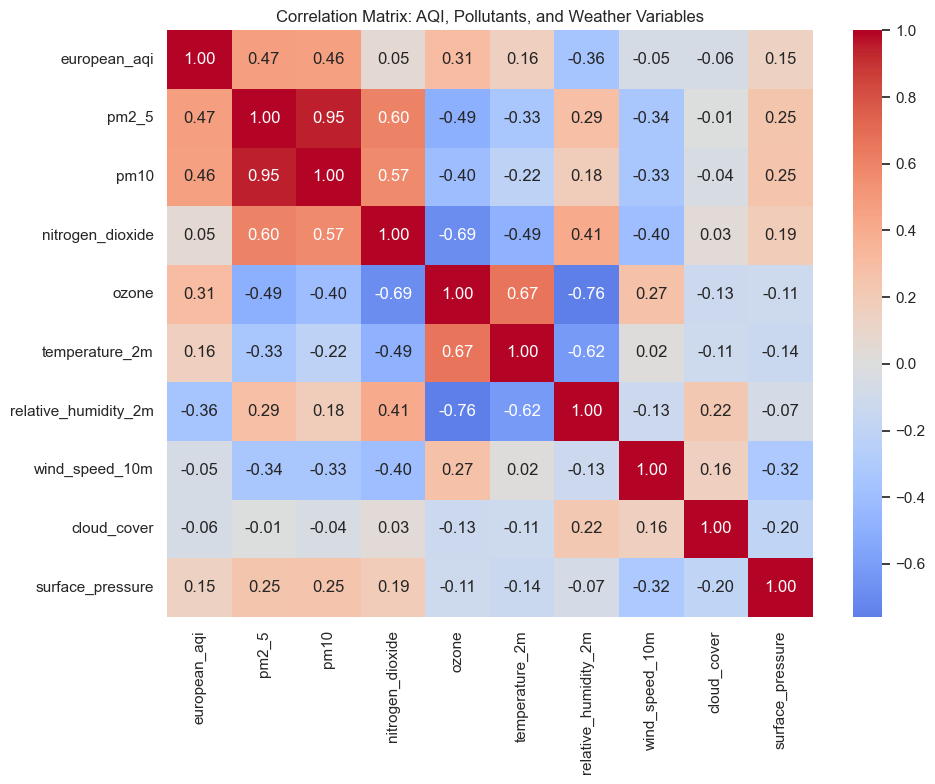

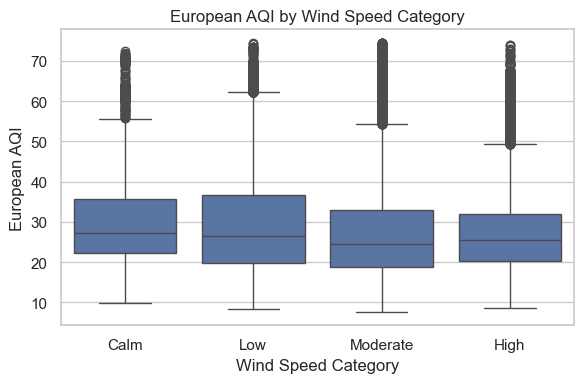

In [32]:
sns.set(style="whitegrid")

weather_vars = [
    "temperature_2m",
    "relative_humidity_2m",
    "wind_speed_10m",
    "cloud_cover",
    "surface_pressure"
]

# ----------------------------------
# 1. Scatter plots with LOWESS smoothing
# ----------------------------------
sampled = berlin.sample(n=10000, random_state=42)

for var in weather_vars:
    plt.figure(figsize=(6,4))
    sns.regplot(
        data=sampled,
        x=var,
        y="european_aqi",
        lowess=True,
        scatter_kws={"alpha": 0.1, "s": 10},
        line_kws={"color": "red"}
    )
    plt.title(f"European AQI vs {var}")
    plt.tight_layout()
    plt.show()

# ----------------------------------
# 2. Correlation heatmap
# ----------------------------------
corr_vars = [
    "european_aqi",
    "pm2_5",
    "pm10",
    "nitrogen_dioxide",
    "ozone",
    "temperature_2m",
    "relative_humidity_2m",
    "wind_speed_10m",
    "cloud_cover",
    "surface_pressure"
]

corr_matrix = berlin[corr_vars].corr()

plt.figure(figsize=(10,8))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    center=0
)
plt.title("Correlation Matrix: AQI, Pollutants, and Weather Variables")
plt.tight_layout()
plt.show()

# ----------------------------------
# 3. AQI vs Wind Speed bins (dispersion effect)
# ----------------------------------
berlin["wind_bin"] = pd.cut(
    berlin["wind_speed_10m"],
    bins=[0, 2, 5, 8, 20],
    labels=["Calm", "Low", "Moderate", "High"]
)

plt.figure(figsize=(6,4))
sns.boxplot(
    data=berlin,
    x="wind_bin",
    y="european_aqi"
)
plt.title("European AQI by Wind Speed Category")
plt.xlabel("Wind Speed Category")
plt.ylabel("European AQI")
plt.tight_layout()
plt.show()


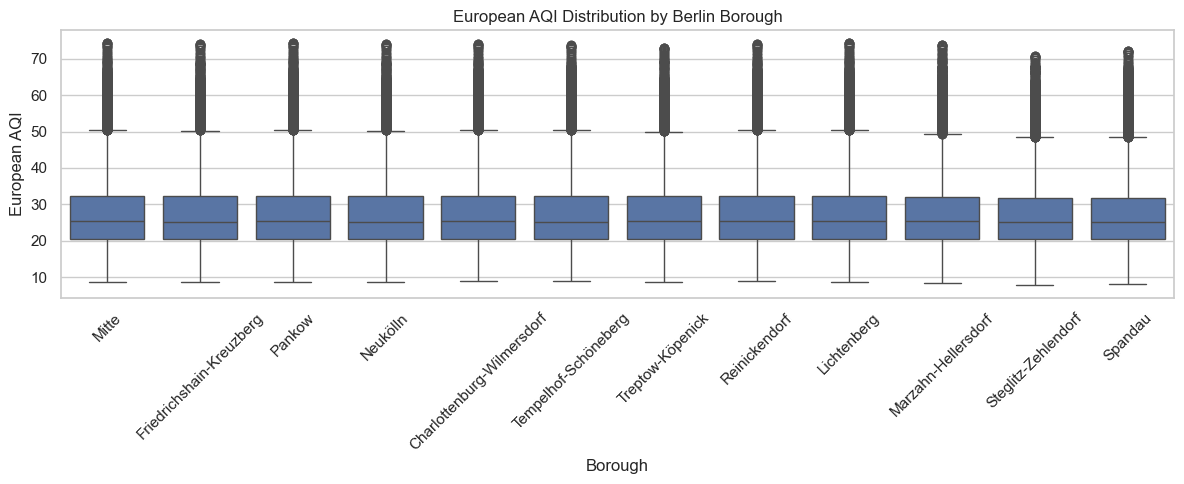

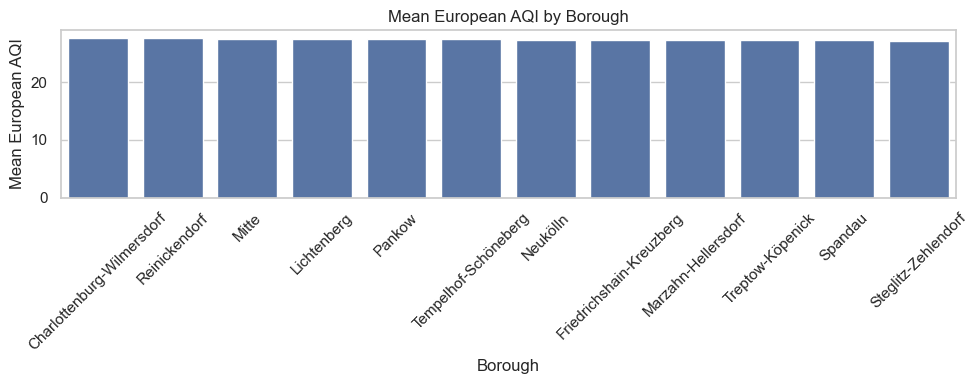

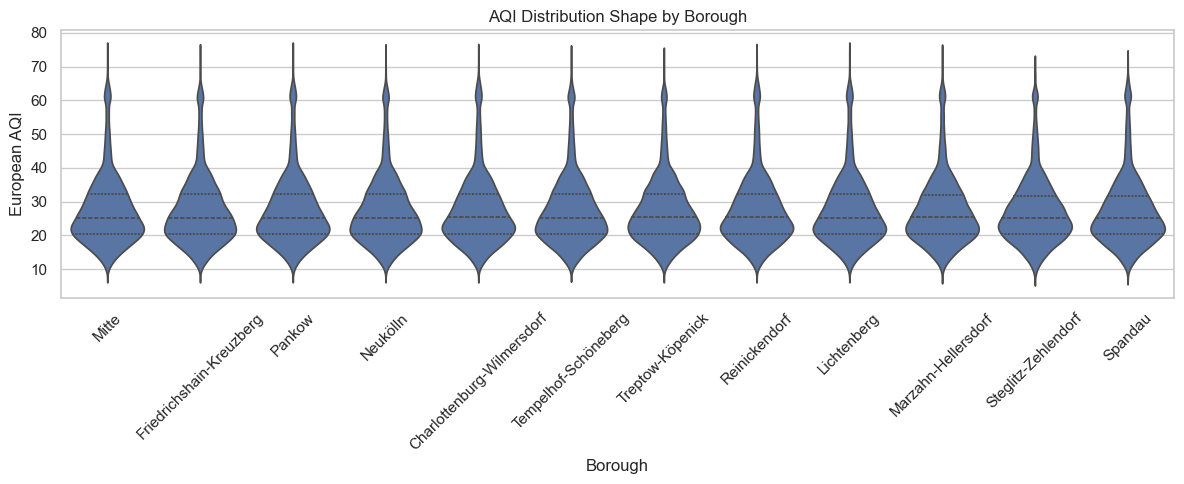

In [33]:
sns.set(style="whitegrid")

# ----------------------------------
# 1. Boxplots: AQI by borough
# ----------------------------------
plt.figure(figsize=(12,5))
sns.boxplot(
    data=berlin,
    x="spatial_alias",
    y="european_aqi"
)
plt.xticks(rotation=45)
plt.title("European AQI Distribution by Berlin Borough")
plt.xlabel("Borough")
plt.ylabel("European AQI")
plt.tight_layout()
plt.show()

# ----------------------------------
# 2. Mean AQI by borough (with variability)
# ----------------------------------
borough_stats = (
    berlin
    .groupby("spatial_alias")["european_aqi"]
    .agg(["mean", "std", "count"])
    .sort_values("mean", ascending=False)
)

plt.figure(figsize=(10,4))
sns.barplot(
    x=borough_stats.index,
    y=borough_stats["mean"]
)
plt.xticks(rotation=45)
plt.title("Mean European AQI by Borough")
plt.xlabel("Borough")
plt.ylabel("Mean European AQI")
plt.tight_layout()
plt.show()

# ----------------------------------
# 3. Violin plot (distribution shape)
# ----------------------------------
plt.figure(figsize=(12,5))
sns.violinplot(
    data=berlin,
    x="spatial_alias",
    y="european_aqi",
    inner="quartile"
)
plt.xticks(rotation=45)
plt.title("AQI Distribution Shape by Borough")
plt.xlabel("Borough")
plt.ylabel("European AQI")
plt.tight_layout()
plt.show()


C:\Users\Gaurav\AppData\Local\Temp\ipykernel_6400\843744242.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby(pd.Grouper(key="date", freq="M"))["european_aqi"]


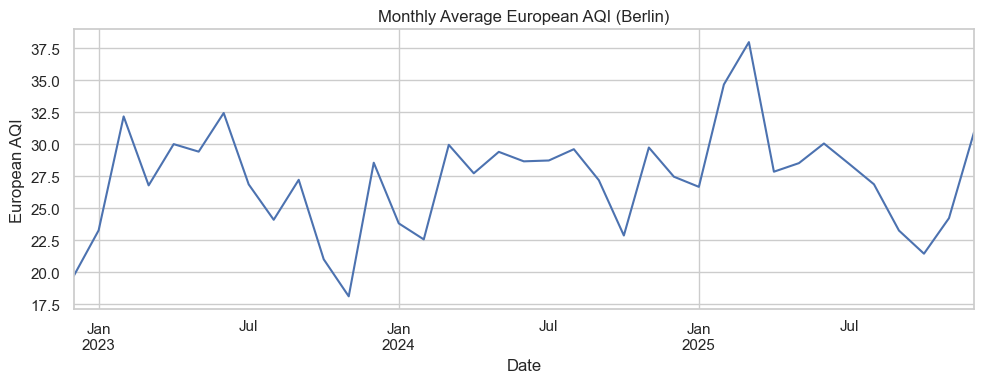

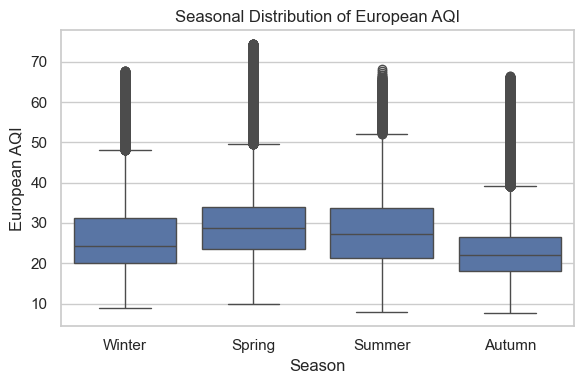

<Figure size 800x400 with 0 Axes>

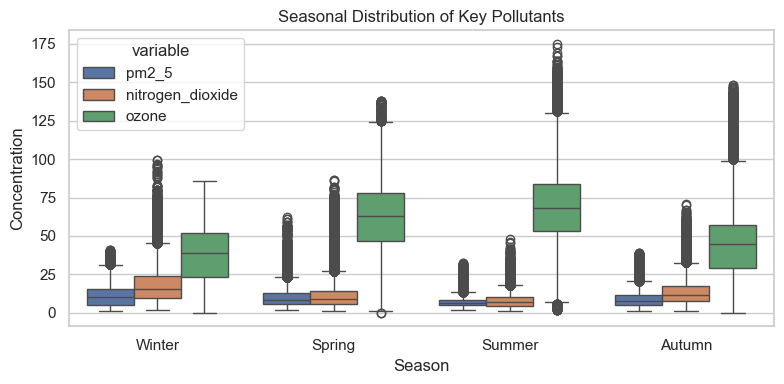

In [34]:
sns.set(style="whitegrid")

# ----------------------------------
# 1. Create time-based features
# ----------------------------------
berlin["month"] = berlin["date"].dt.month
berlin["year"] = berlin["date"].dt.year
berlin["season"] = berlin["month"].map({
    12: "Winter", 1: "Winter", 2: "Winter",
    3: "Spring", 4: "Spring", 5: "Spring",
    6: "Summer", 7: "Summer", 8: "Summer",
    9: "Autumn", 10: "Autumn", 11: "Autumn"
})

# ----------------------------------
# 2. Monthly average AQI (overall)
# ----------------------------------
monthly_aqi = (
    berlin
    .groupby(pd.Grouper(key="date", freq="M"))["european_aqi"]
    .mean()
)

plt.figure(figsize=(10,4))
monthly_aqi.plot()
plt.title("Monthly Average European AQI (Berlin)")
plt.xlabel("Date")
plt.ylabel("European AQI")
plt.tight_layout()
plt.show()

# ----------------------------------
# 3. Seasonal AQI comparison
# ----------------------------------
plt.figure(figsize=(6,4))
sns.boxplot(
    data=berlin,
    x="season",
    y="european_aqi",
    order=["Winter", "Spring", "Summer", "Autumn"]
)
plt.title("Seasonal Distribution of European AQI")
plt.xlabel("Season")
plt.ylabel("European AQI")
plt.tight_layout()
plt.show()

# ----------------------------------
# 4. Seasonal comparison of key pollutants
# ----------------------------------
pollutants = ["pm2_5", "nitrogen_dioxide", "ozone"]

plt.figure(figsize=(8,4))
melted = pd.melt(
    berlin,
    id_vars="season",
    value_vars=pollutants
)

plt.figure(figsize=(8,4))
sns.boxplot(
    data=melted,
    x="season",
    y="value",
    hue="variable",
    order=["Winter", "Spring", "Summer", "Autumn"]
)
plt.title("Seasonal Distribution of Key Pollutants")
plt.xlabel("Season")
plt.ylabel("Concentration")
plt.tight_layout()
plt.show()


In [35]:
# Model with borough as categorical variable

formula = """
european_aqi ~
C(spatial_alias) + 
temperature_2m +
relative_humidity_2m +
wind_speed_10m +
cloud_cover +
surface_pressure
"""

model = smf.ols(formula, data=berlin).fit()
# print(model.summary())


In [36]:
# Tukey's HSD test for pairwise borough comparisons

tukey = pairwise_tukeyhsd(
    endog=berlin["european_aqi"],
    groups=berlin["spatial_alias"],
    alpha=0.05
)

print(tukey.summary())


                   Multiple Comparison of Means - Tukey HSD, FWER=0.05                    
          group1                    group2          meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------------
Charlottenburg-Wilmersdorf Friedrichshain-Kreuzberg  -0.2398 0.2408 -0.5332  0.0536  False
Charlottenburg-Wilmersdorf              Lichtenberg  -0.1189 0.9761 -0.4124  0.1745  False
Charlottenburg-Wilmersdorf      Marzahn-Hellersdorf   -0.242 0.2285 -0.5354  0.0515  False
Charlottenburg-Wilmersdorf                    Mitte  -0.1189 0.9761 -0.4124  0.1745  False
Charlottenburg-Wilmersdorf                 Neukölln  -0.2398 0.2408 -0.5332  0.0536  False
Charlottenburg-Wilmersdorf                   Pankow  -0.1189 0.9761 -0.4124  0.1745  False
Charlottenburg-Wilmersdorf            Reinickendorf      0.0    1.0 -0.2934  0.2934  False
Charlottenburg-Wilmersdorf                  Spandau  -0.3822 0.0013 -0.6756 -0.0887   True

In [37]:
# Borough pairwise t-tests (Alpha Bonferroni Correction)

import itertools
from scipy.stats import ttest_ind

districts = berlin["spatial_alias"].unique()
results = []

for d1, d2 in itertools.combinations(districts, 2):
    g1 = berlin[berlin["spatial_alias"] == d1]["european_aqi"]
    g2 = berlin[berlin["spatial_alias"] == d2]["european_aqi"]
    
    stat, p = ttest_ind(g1, g2, equal_var=False)
    results.append((d1, d2, p))

results_df = pd.DataFrame(results, columns=["District1", "District2", "p_value"])

alpha_bonf = 0.05 / len(results_df)
print(len(results_df))

significant = results_df[results_df["p_value"] < alpha_bonf]
significant


66


,District1,District2,p_value
9,Mitte,Steglitz-Zehlendorf,1.421830e-06
19,Friedrichshain-Kreuzberg,Steglitz-Zehlendorf,5.034651e-04
28,Pankow,Steglitz-Zehlendorf,1.421830e-06
36,Neukölln,Steglitz-Zehlendorf,5.034651e-04
43,Charlottenburg-Wilmersdorf,Steglitz-Zehlendorf,9.407148e-10
44,Charlottenburg-Wilmersdorf,Spandau,2.774575e-05
49,Tempelhof-Schöneberg,Steglitz-Zehlendorf,1.223804e-04
58,Reinickendorf,Steglitz-Zehlendorf,9.407148e-10
59,Reinickendorf,Spandau,2.774575e-05
61,Lichtenberg,Steglitz-Zehlendorf,1.421830e-06


In [38]:
# Borough pairwise t-tests with effect sizes

import pingouin as pg

results = pg.pairwise_ttests(
    data=berlin,
    dv="european_aqi",
    between="spatial_alias",
    parametric=True,
    padjust="bonf",
    effsize="cohen",
)

results = results[results["p-corr"] < 0.05]
# results
results[["A", "B", "p-unc", "p-corr"]]

d:\Urban Tech\venv\Lib\site-packages\pingouin\pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,A,B,p-unc,p-corr
7,Charlottenburg-Wilmersdorf,Spandau,2.773979e-05,1.830826e-03
8,Charlottenburg-Wilmersdorf,Steglitz-Zehlendorf,9.403444e-10,6.206273e-08
18,Friedrichshain-Kreuzberg,Steglitz-Zehlendorf,5.033838e-04,3.322333e-02
27,Lichtenberg,Steglitz-Zehlendorf,1.421641e-06,9.382828e-05
35,Marzahn-Hellersdorf,Steglitz-Zehlendorf,5.273643e-04,3.480604e-02
42,Mitte,Steglitz-Zehlendorf,1.421641e-06,9.382828e-05
48,Neukölln,Steglitz-Zehlendorf,5.033838e-04,3.322333e-02
53,Pankow,Steglitz-Zehlendorf,1.421641e-06,9.382828e-05
56,Reinickendorf,Spandau,2.773979e-05,1.830826e-03
57,Reinickendorf,Steglitz-Zehlendorf,9.403444e-10,6.206273e-08


In [39]:
# For each pair, determine which borough has the lower mean AQI

means = (
    berlin
    .groupby("spatial_alias")["european_aqi"]
    .mean()
)

results["mean_A"] = results["A"].map(means)
results["mean_B"] = results["B"].map(means)

results["better"] = results.apply(
    lambda r: r["A"] if r["mean_A"] < r["mean_B"] else r["B"],
    axis=1
)

results[["A", "B", "mean_A", "mean_B", "better", "p-corr"]]


,A,B,mean_A,mean_B,better,p-corr
7,Charlottenburg-Wilmersdorf,Spandau,27.652447,27.270285,Spandau,1.830826e-03
8,Charlottenburg-Wilmersdorf,Steglitz-Zehlendorf,27.652447,27.108223,Steglitz-Zehlendorf,6.206273e-08
18,Friedrichshain-Kreuzberg,Steglitz-Zehlendorf,27.412643,27.108223,Steglitz-Zehlendorf,3.322333e-02
27,Lichtenberg,Steglitz-Zehlendorf,27.533503,27.108223,Steglitz-Zehlendorf,9.382828e-05
35,Marzahn-Hellersdorf,Steglitz-Zehlendorf,27.410484,27.108223,Steglitz-Zehlendorf,3.480604e-02
42,Mitte,Steglitz-Zehlendorf,27.533503,27.108223,Steglitz-Zehlendorf,9.382828e-05
48,Neukölln,Steglitz-Zehlendorf,27.412643,27.108223,Steglitz-Zehlendorf,3.322333e-02
53,Pankow,Steglitz-Zehlendorf,27.533503,27.108223,Steglitz-Zehlendorf,9.382828e-05
56,Reinickendorf,Spandau,27.652447,27.270285,Spandau,1.830826e-03
57,Reinickendorf,Steglitz-Zehlendorf,27.652447,27.108223,Steglitz-Zehlendorf,6.206273e-08


In [40]:
formula = """
european_aqi ~ 
temperature_2m +
relative_humidity_2m +
wind_speed_10m +
cloud_cover +
surface_pressure
"""

tscv = TimeSeriesSplit(n_splits=5)
scores = []

# X_cols = [
#     "temperature_2m",
#     "relative_humidity_2m",
#     "wind_speed_10m",
#     "cloud_cover",
#     "surface_pressure"
# ]

for train_idx, test_idx in tscv.split(berlin):
    train = berlin.iloc[train_idx]
    test = berlin.iloc[test_idx]

    m = smf.ols(formula, data=train).fit()
    preds = m.predict(test)

    scores.append(r2_score(test["european_aqi"], preds))

print("Time-block CV R² scores:", scores)
print("Mean CV R²:", sum(scores) / len(scores))


Time-block CV R² scores: [0.15505751093556353, 0.14249835661677468, 0.15759810148218312, 0.15261696894993537, 0.16004616580494335]
Mean CV R²: 0.15356342075788001


In [41]:
# Scaled version

X_cols = [
    "temperature_2m",
    "relative_humidity_2m",
    "wind_speed_10m",
    "cloud_cover",
    "surface_pressure"
]

tscv = TimeSeriesSplit(n_splits=5)
scores = []

for train_idx, test_idx in tscv.split(berlin):
    train = berlin.iloc[train_idx].copy()
    test = berlin.iloc[test_idx].copy()

    scaler = StandardScaler()
    train[X_cols] = scaler.fit_transform(train[X_cols])
    test[X_cols] = scaler.transform(test[X_cols])

    X_train = sm.add_constant(train[X_cols])
    y_train = train["european_aqi"]

    X_test = sm.add_constant(test[X_cols])
    y_test = test["european_aqi"]

    model = sm.OLS(y_train, X_train).fit()
    preds = model.predict(X_test)

    scores.append(r2_score(y_test, preds))

print("Time-block CV R² scores:", scores)
print("Mean CV R²:", sum(scores) / len(scores))


Time-block CV R² scores: [0.155057510663262, 0.14249835625659335, 0.15759810053545287, 0.15261696674183134, 0.16004616729581744]
Mean CV R²: 0.1535634202985914


In [42]:
# After controlling for weather, compare boroughs

model_weather = smf.ols("european_aqi ~ temperature_2m + wind_speed_10m + relative_humidity_2m + " \
"cloud_cover + surface_pressure", data=berlin).fit()
berlin["resid_aqi"] = model_weather.resid

results = pg.pairwise_tests(
    data=berlin,
    dv="resid_aqi",
    between="spatial_alias",
    parametric=True,
    padjust="bonf", 
    effsize="cohen"
)

results = results[results["p-corr"] < 0.05]
results[["A", "B", "p-unc", "p-corr"]]

,A,B,p-unc,p-corr
6,Charlottenburg-Wilmersdorf,Reinickendorf,1.145532e-05,7.560509e-04
8,Charlottenburg-Wilmersdorf,Steglitz-Zehlendorf,4.262252e-05,2.813087e-03
10,Charlottenburg-Wilmersdorf,Treptow-Köpenick,3.198540e-04,2.111036e-02
11,Friedrichshain-Kreuzberg,Lichtenberg,1.143233e-05,7.545341e-04
12,Friedrichshain-Kreuzberg,Marzahn-Hellersdorf,1.410189e-07,9.307244e-06
15,Friedrichshain-Kreuzberg,Pankow,6.231195e-07,4.112589e-05
16,Friedrichshain-Kreuzberg,Reinickendorf,2.463534e-11,1.625932e-09
23,Lichtenberg,Neukölln,1.266878e-04,8.361393e-03
26,Lichtenberg,Spandau,4.699815e-06,3.101878e-04
27,Lichtenberg,Steglitz-Zehlendorf,1.687898e-10,1.114013e-08
